## 1. Import bibliotek

In [4]:
# 1. Import potrzebnych bibliotek

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Pobranie słownika do analizy sentymentu
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Julia.ch\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

##  2. Wczytanie danych z pliku Reviews.csv

In [5]:
# Wczytanie danych z pliku CSV do DataFrame
df = pd.read_csv("Reviews.csv")

# Wyświetlenie pierwszych 5 wierszy, żeby sprawdzić strukturę danych
df.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## 3. Sprawdzanie brakujących danych

In [6]:
# Sprawdzenie, ile brakuje wartości w każdej kolumnie
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

## 4. Czyszczenie danych

In [7]:
# Usuwanie wszystkich wierszy, w których występują braki danych
df = df.dropna()

# Sprawdzenie ponownie, czy wszystkie braki danych zostały usunięte
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

## 5. Przekształcenie ocen (Score) na etykiety sentymentu (Sentiment)

In [8]:
def get_sentiment(score):
    if score in [1, 2]:
        return 'negatywny'
    elif score == 3:
        return 'neutralny'
    else:
        return 'pozytywny'

# Utworzenie nowej kolumny z kategorią sentymentu
df['Sentiment'] = df['Score'].apply(get_sentiment)

# Sprawdzenie liczby przykładów w każdej kategorii
df['Sentiment'].value_counts()

Sentiment
pozytywny    443756
negatywny     82007
neutralny     42638
Name: count, dtype: int64

## 6. Analiza sentymentu tekstu za pomocą VADER (NLTK)

In [9]:
# Utworzenie obiektu analizatora sentymentu
sia = SentimentIntensityAnalyzer()

# Przykład: analiza jednego tekstu
print(df['Text'].iloc[0])
print(sia.polarity_scores(df['Text'].iloc[0]))

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
{'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'compound': 0.9441}


## 7. Przetworzenie wszystkich tekstów — klasyfikacja sentymentu z VADER

In [10]:
# Funkcja do przypisania etykiety na podstawie wartości compound
def vader_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'pozytywny'
    elif score <= -0.05:
        return 'negatywny'
    else:
        return 'neutralny'

# Zastosowanie funkcji do całej kolumny Text
df['Predicted_Sentiment'] = df['Text'].apply(vader_sentiment)

# Podgląd wyników
df[['Text', 'Sentiment', 'Predicted_Sentiment']].head()

,Text,Sentiment,Predicted_Sentiment
0,I have bought several of the Vitality canned d...,pozytywny,pozytywny
1,Product arrived labeled as Jumbo Salted Peanut...,negatywny,negatywny
2,This is a confection that has been around a fe...,pozytywny,pozytywny
3,If you are looking for the secret ingredient i...,negatywny,neutralny
4,Great taffy at a great price. There was a wid...,pozytywny,pozytywny


## 8. Ewaluacja skuteczności predykcji – porównanie etykiet

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

# Porównanie etykiet: Score vs VADER
print(confusion_matrix(df['Sentiment'], df['Predicted_Sentiment']))
print("\nRaport klasyfikacji:\n")
print(classification_report(df['Sentiment'], df['Predicted_Sentiment']))


[[ 32912   4092  45003]
 [  7628   1579  33431]
 [ 18767   6481 418508]]

Raport klasyfikacji:

              precision    recall  f1-score   support

   negatywny       0.55      0.40      0.47     82007
   neutralny       0.13      0.04      0.06     42638
   pozytywny       0.84      0.94      0.89    443756

    accuracy                           0.80    568401
   macro avg       0.51      0.46      0.47    568401
weighted avg       0.75      0.80      0.77    568401



## 9. Wizualizacja macierzy pomyłek

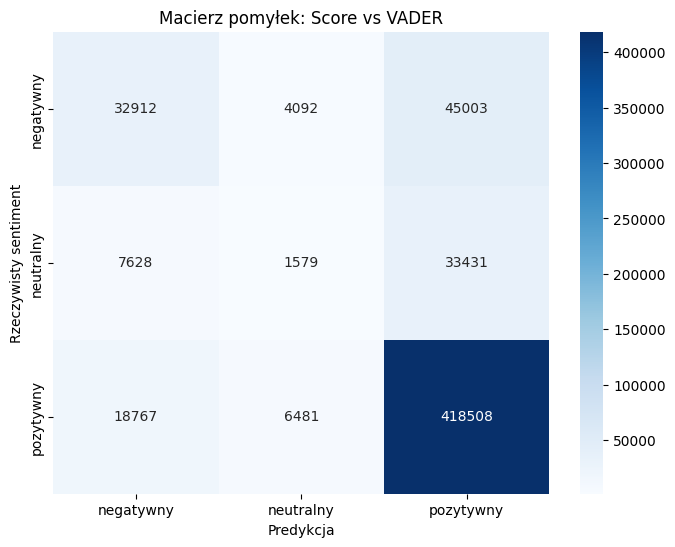

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Obliczenie macierzy pomyłek
cm = confusion_matrix(df['Sentiment'], df['Predicted_Sentiment'])

# Definicja etykiet klas
labels = ['negatywny', 'neutralny', 'pozytywny']

# Tworzenie wykresu
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Opisy osi
plt.xlabel('Predykcja')
plt.ylabel('Rzeczywisty sentiment')
plt.title('Macierz pomyłek: Score vs VADER')

# Wyświetlenie
plt.show()


## 9. Dokładność klasyfikatora

In [13]:
# Obliczenie dokładności klasyfikatora
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(df['Sentiment'], df['Predicted_Sentiment'])
print(f'Dokładność klasyfikatora VADER: {accuracy:.4f}')

Dokładność klasyfikatora VADER: 0.7970


## 10. Podsumowanie końcowe projektu

In [ ]:
# Podsumowanie projektu analizy sentymentu
print("✅ Projekt został zakończony pomyślnie. Wykonano następujące kroki:")
print("1. Wczytanie danych i oczyszczenie ich z brakujących wartości.")
print("2. Eksploracja danych i sprawdzenie rozkładu klas.")
print("3. Analiza sentymentu tekstów za pomocą VADER (NLTK).")
print("4. Klasyfikacja sentymentów jako: pozytywny, neutralny lub negatywny.")
print("5. Porównanie etykiet VADER z etykietami rzeczywistymi (Score).")
print("6. Wyświetlenie macierzy pomyłek oraz metryk klasyfikacyjnych.")
print(f"7. Uzyskana dokładność klasyfikatora VADER: {accuracy:.2%}")
